In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_d = pd.read_csv("Dutch_paydiff_norm_zerocost.csv")
df_h = pd.read_csv("Honolulu_paydiff_norm_zerocost.csv")
df_d = df_d[df_d["subsession.round_number"] > 2]
df_h = df_h[df_h["subsession.round_number"] > 2]

In [3]:
dict_d = {
    (2, 0.019): dict(),
    (2, 0.009): dict(),
    (5, 0.019): dict(),
    (5, 0.009): dict(),
}

for index, row in df_d.iterrows():

    n = int(row["session.config.name"][1])
    b = row["session.config.discount_b"]
    key1 = (n, b)

    code = row["session.code"]
    round = row["subsession.round_number"]
    group = row["group.id_in_subsession"]
    key2 = (code, round, group)

    have_winner = row["group.have_dutch_winner"]
    is_winner = row["player.is_dutch_winner"]
    final_price = row["group.dutch_final_price"]
    duration = row["group.dutch_time_elapsed"]

    pred_is_winner = row["predict.player.is_dutch_winner"]
    pred0_is_winner = row["predict0.player.is_dutch_winner"]

    if key2 not in dict_d[key1].keys():
        dict_d[key1][key2] = {
            "have_winner": have_winner,
            "final_price": final_price,
            "duration": duration,
            "ua": row["group.auctioneer_utility"],
            "pred_final_price": row["predict.group.dutch_final_price"],
            "pred_duration": row["predict.group.dutch_time_elapsed"],
            "pred_ua": row["predict.group.auctioneer_utility"],
            "pred0_final_price": row["predict0.group.dutch_final_price"],
            "pred0_duration": row["predict0.group.dutch_time_elapsed"],
            "pred0_ua": row["predict0.group.auctioneer_utility"],
        }

    if is_winner:
        diff = row["player.item_value"] - final_price
        if diff >= 0:
            dict_d[key1][key2]["ub"] = diff * (1 - b * duration)
        else:
            dict_d[key1][key2]["ub"] = diff * (1 + b * duration)
        dict_d[key1][key2]["ub_rounded"] = row["player.payoff"]

    if pred_is_winner:
        dict_d[key1][key2]["pred_ub"] = row["predict.player.payoff"]

    if pred0_is_winner:
        dict_d[key1][key2]["pred0_ub"] = row["predict0.player.payoff"]
    
    if is_winner:
        max_value = np.max(df_d[(df_d["session.code"] == code) & (df_d["subsession.round_number"] == round) & (df_d["group.id_in_subsession"] == group)]["player.item_value"])
        dict_d[key1][key2]["efficiency"] = row["player.item_value"] / max_value * 100
    elif not have_winner:
        dict_d[key1][key2]["efficiency"] = 0

In [4]:
dict_h = {
    (2, 0.019): dict(),
    (2, 0.009): dict(),
    (5, 0.019): dict(),
    (5, 0.009): dict(),
}

for index, row in df_h.iterrows():

    n = int(row["session.config.name"][1])
    b = row["session.config.discount_b"]
    key1 = (n, b)

    code = row["session.code"]
    round = row["subsession.round_number"]
    group = row["group.id_in_subsession"]
    key2 = (code, round, group)

    have_winner = row["group.have_contest_winner"]
    is_winner = row["player.is_final_winner"]
    final_price = row["group.final_price"]
    duration = row["group.dutch_time_elapsed"] + row["group.english_time_elapsed"]

    pred_is_winner = row["predict.player.is_final_winner"]
    pred0_is_winner = row["predict0.player.is_final_winner"]

    if key2 not in dict_h[key1].keys():
        dict_h[key1][key2] = {
            "have_winner": have_winner,
            "final_price": final_price,
            "duration": duration,
            "ua": row["group.auctioneer_utility"],
            "pred_final_price": row["predict.group.final_price"],
            "pred_duration": row["predict.group.dutch_time_elapsed"] + row["predict.group.english_time_elapsed"],
            "pred_ua": row["predict.group.auctioneer_utility"],
            "pred0_final_price": row["predict0.group.final_price"],
            "pred0_duration": row["predict0.group.dutch_time_elapsed"] + row["predict0.group.english_time_elapsed"],
            "pred0_ua": row["predict0.group.auctioneer_utility"],
        }

    if is_winner:
        diff = row["player.item_value"] - final_price
        if diff >= 0:
            dict_h[key1][key2]["ub"] = (row["player.item_value"] - final_price) * (1 - b * duration)
        else:
            dict_h[key1][key2]["ub"] = (row["player.item_value"] - final_price) * (1 + b * duration)
        dict_h[key1][key2]["ub_rounded"] = row["player.payoff"]
        
    if pred_is_winner:
        dict_h[key1][key2]["pred_ub"] = row["predict.player.payoff"]

    if pred0_is_winner:
        dict_h[key1][key2]["pred0_ub"] = row["predict0.player.payoff"]
    
    if is_winner:
        max_value = np.max(df_h[(df_h["session.code"] == code) & (df_h["subsession.round_number"] == round) & (df_h["group.id_in_subsession"] == group)]["player.item_value"])
        dict_h[key1][key2]["efficiency"] = row["player.item_value"] / max_value * 100
    elif not have_winner:
        dict_h[key1][key2]["efficiency"] = 0

## Auction characteristics

In [5]:
def Efficiency(n, b):
    key1 = (n, b)
    tmp = []
    for key2 in dict_d[key1].keys():
        tmp.append(dict_d[key1][key2]["efficiency"])
    eff_d = np.average(tmp)        
    tmp = []
    for key2 in dict_d[key1].keys():
        tmp.append(dict_h[key1][key2]["efficiency"])
    eff_h = np.average(tmp)
    return eff_d, eff_h

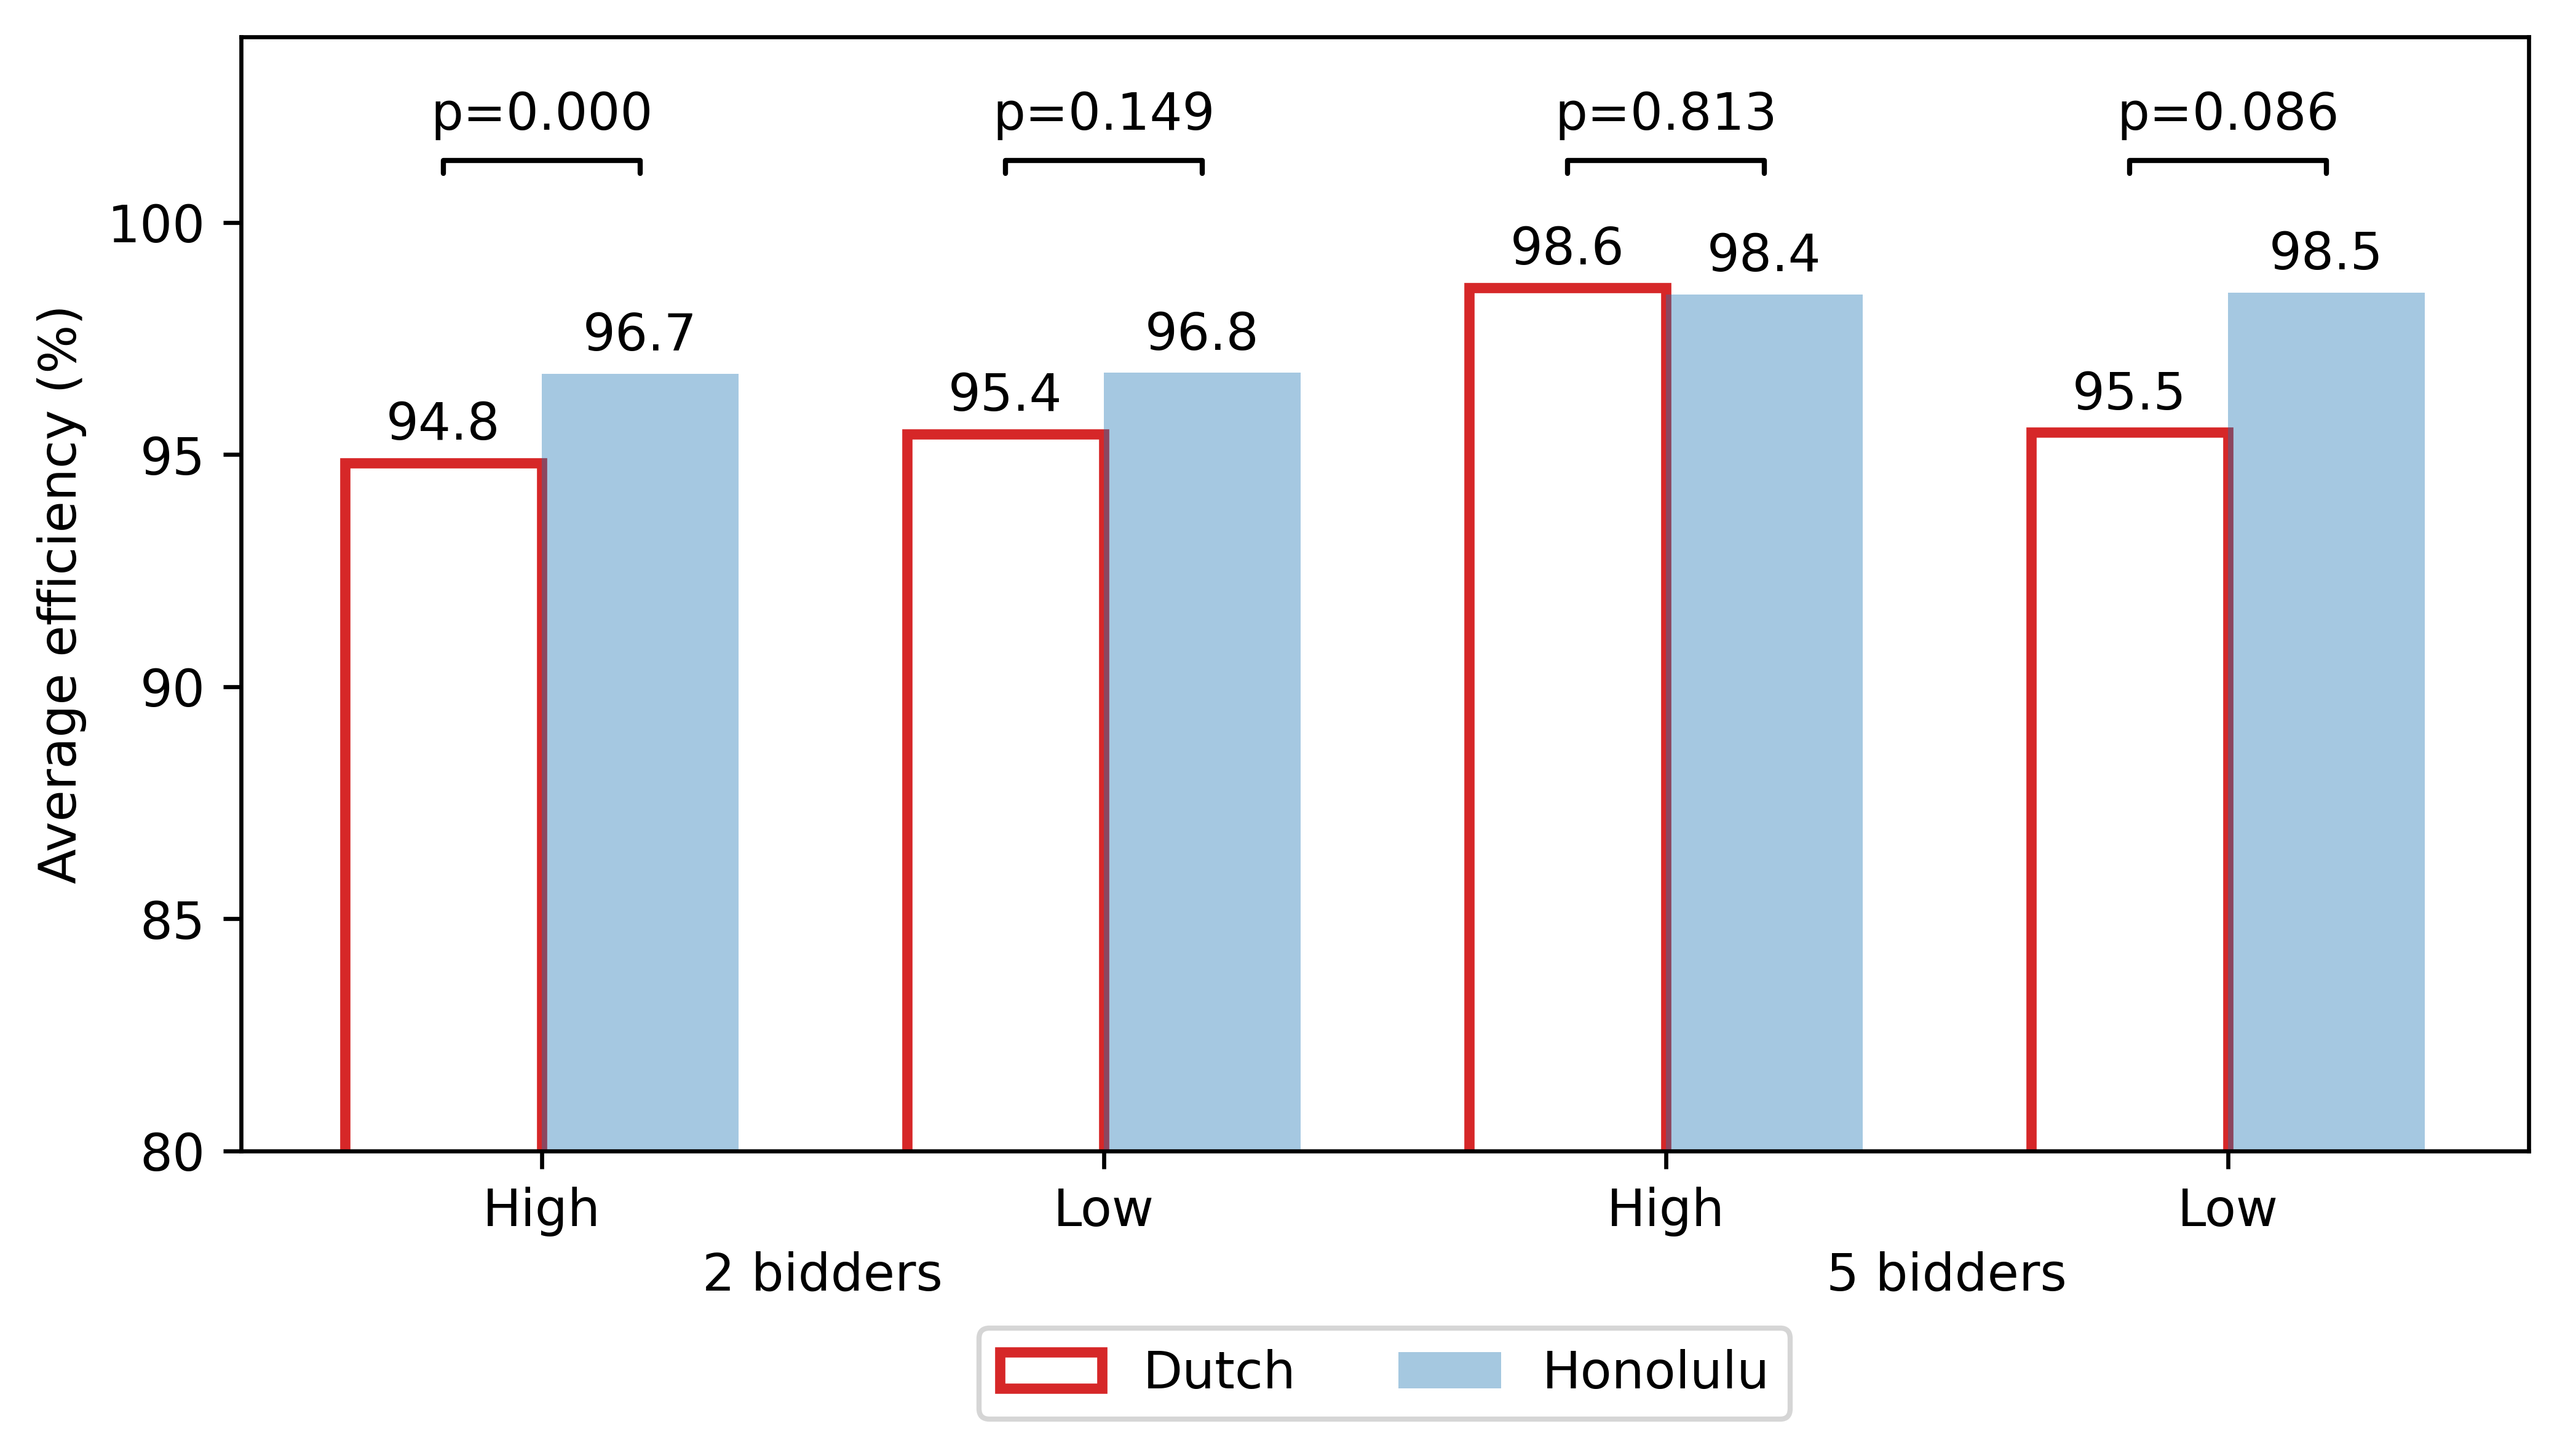

In [6]:
plt.figure(figsize=(8, 4), dpi=600)
x = np.array([1, 2, 3, 4])
wd = 0.35
ybot = 80
y1 = []
y2 = []
for n in [2, 5]:
    for b in [0.019, 0.009]:
        tmp1, tmp2 = Efficiency(n, b)
        y1.append(tmp1)
        y2.append(tmp2)
plt.bar(x - 0.5 * wd, y1, width=wd, edgecolor="C3", fill=False, linewidth=2, label="Dutch")
plt.bar(x + 0.5 * wd, y2, width=wd, color="C0", alpha=0.4, label="Honolulu")

for a, b in zip(x, y1):
    plt.text(a - 0.5 * wd, b + 0.5, "%.1f" % b, ha="center", color="black", fontsize="medium")
for a, b in zip(x, y2):
    plt.text(a + 0.5 * wd, b + 0.5, "%.1f" % b, ha="center", color="black", fontsize="medium")

props = dict(
    connectionstyle = "bar, armA=0, armB=0, fraction=0.08",
    arrowstyle = "-",
    shrinkA = 0.5,
    shrinkB = 0.5,
    linewidth = 1,
)
p = [0.000, 0.149, 0.813, 0.086]
for i in range(len(x)):
    plt.annotate("", (x[i] - 0.5 * wd, 101), (x[i] + 0.5 * wd, 101), arrowprops=props)
    plt.annotate("p=%.3f" % p[i], (x[i], 102), ha="center", fontsize="medium")

plt.ylim(ybot, 104)
plt.yticks(np.arange(ybot, 101, 5), fontsize="medium")
plt.xticks(x, ["High", "Low", "High", "Low"], fontsize="medium")
plt.ylabel("Average efficiency (%)", fontsize="medium")

plt.annotate("2 bidders", (1.5, ybot), (1.5, ybot-3), ha="center", fontsize="medium")
plt.annotate("5 bidders", (3.5, 80), (3.5, ybot-3), ha="center", fontsize="medium")
plt.legend(ncol=2, loc="center", bbox_to_anchor=(0.5, -0.2), fontsize="medium")
# plt.title("Auction efficiency by treatment", pad=20, fontsize="large")

plt.savefig("bar_efficiency_all_pyplot.png", bbox_inches="tight", format="png")

In [90]:
def Duration(n, b, ax):

    key1 = (n, b)

    tmp_a, tmp_p, tmp_z = [], [], []
    for key2 in dict_d[key1].keys():
        tmp_a.append(dict_d[key1][key2]["duration"])
        tmp_p.append(dict_d[key1][key2]["pred_duration"])
        tmp_z.append(dict_d[key1][key2]["pred0_duration"])
    act_d, pre_d, pre0_d = np.average(tmp_a), np.average(tmp_p), np.average(tmp_z)

    tmp_a, tmp_p, tmp_z = [], [], []
    for key2 in dict_h[key1].keys():
        tmp_a.append(dict_h[key1][key2]["duration"])
        tmp_p.append(dict_h[key1][key2]["pred_duration"])
        tmp_z.append(dict_h[key1][key2]["pred0_duration"])
    act_h, pre_h, pre0_h = np.average(tmp_a), np.average(tmp_p), np.average(tmp_z)

    y1 = [act_d, act_h]
    y2 = [pre_d, pre_h]
    y3 = [pre0_d, pre0_h]
    x = np.array([1, 2])
    
    wd = 0.35
    ax.bar(x - 0.5 * wd, y1, width=wd, color="C5", label="Actual")
    ax.bar(x + 0.5 * wd, y2, width=wd, edgecolor="C4", fill=False, label="Predicted")

    for ta, tb in zip(x, y1):
        ax.text(ta - 0.5 * wd, tb - 3, "%.1f" % tb, ha="center", color="white", fontsize="large")
    for ta, tb in zip(x, y2):
        ax.text(ta + 0.5 * wd, tb - 3, "%.1f" % tb, ha="center", color="black", fontsize="large")
    
    if n == 2:
        pval = 0.000 if b == 0.019 else 0.000
    else:
        pval = 0.158 if b == 0.019 else 0.018
    props = dict(
        connectionstyle = "bar, armA=0, armB=0, fraction=0.08",
        arrowstyle = "-",
        shrinkA = 0.5,
        shrinkB = 0.5,
        linewidth = 1,
    )
    ax.annotate("", (x[0] - 0.5 * wd, 33), (x[1] - 0.5 * wd, 33), arrowprops=props)
    ax.annotate("p=%.3f" % pval, (0.5 * (x[0] + x[1] - wd), 37), ha="center", fontsize="large")

    # wd = 0.2
    # ax.bar(x - wd, y1, width=wd, color="C5", label="Actual")
    # ax.bar(x, y2, width=wd, edgecolor="C4", fill=False, label="Predicted")
    # ax.bar(x + wd, y3, width=wd, edgecolor="C6", fill=False, hatch="//", label="Zero-cost predicted")

    # for ta, tb in zip(x, y1):
    #     ax.text(ta - wd, tb + 1, "%.1f" % tb, ha="center", color="black", fontsize="large")
    # for ta, tb in zip(x, y2):
    #     ax.text(ta, tb + 1, "%.1f" % tb, ha="center", color="black", fontsize="large")
    # for ta, tb in zip(x, y3):
    #     ax.text(ta + wd, tb + 1, "%.1f" % tb, ha="center", color="black", fontsize="large")

    # ax.set_ylim(0, 70)
    # ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70], fontsize="large")
    ax.set_ylim(0, 41)
    ax.set_yticks([0, 10, 20, 30, 40], labels=[0, 10, 20, 30, 40], fontsize="large")
    # ax.set_xticks(x, labels=[str(n) + ("H" if b== 0.019 else "L") + "_Dutch",  str(n) + ("H" if b == 0.019 else "L") + "_Honolulu"], fontsize="large")
    ax.set_xticks(x, labels=["Dutch",  "Honolulu"], fontsize="large")
    if n == 2:
        ax.set_ylabel("Average duration", fontsize="large")
    ax.set_title("Treatment " + str(n) + ("H" if b == 0.019 else "L"), fontsize="x-large")

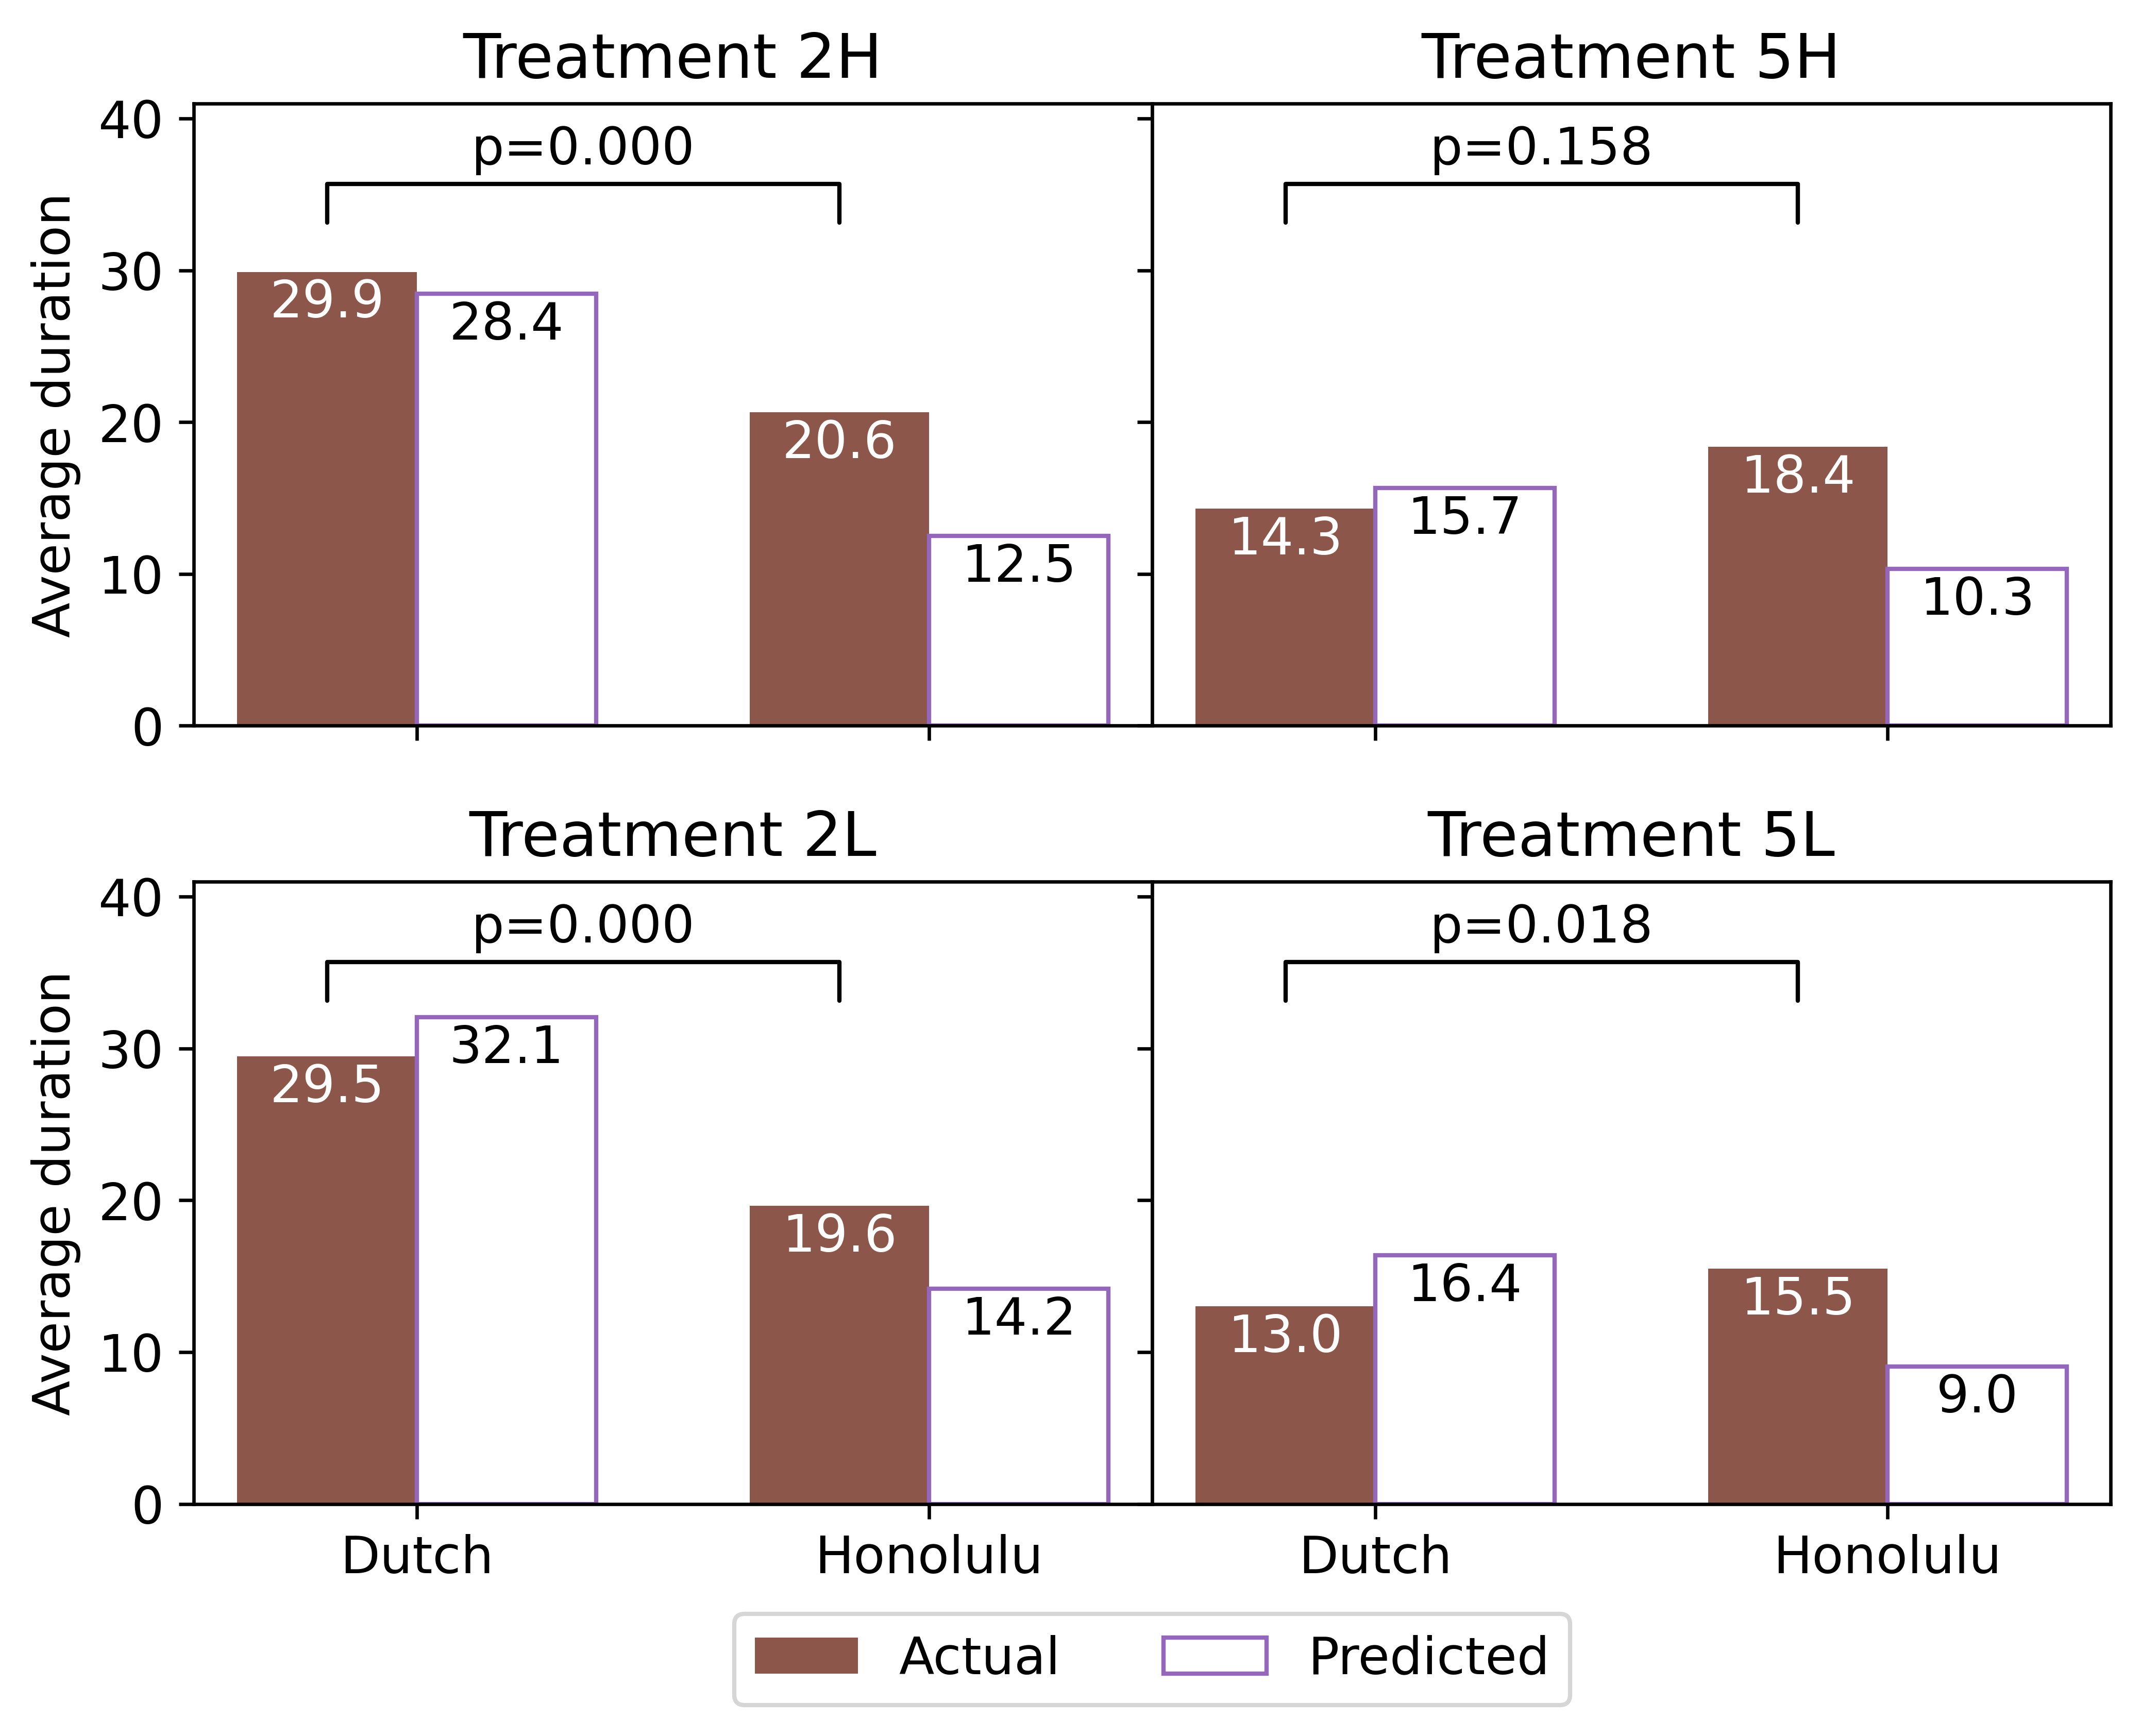

In [108]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=600, facecolor="white", sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.25)
Duration(2, 0.019, ax[0, 0])
Duration(2, 0.009, ax[1, 0])
Duration(5, 0.019, ax[0, 1])
Duration(5, 0.009, ax[1, 1])
plt.legend(ncol=2, loc="center", bbox_to_anchor=(0, -0.25), fontsize="large")

plt.savefig("bar_duration_all_pyplot.png", bbox_inches="tight", format="png")

In [93]:
def Revenue(n, b, ax):
    
    key1 = (n, b)
    
    tmp_a, tmp_p, tmp_z = [], [], []
    for key2 in dict_d[key1].keys():
        tmp_a.append(dict_d[key1][key2]["final_price"])
        tmp_p.append(dict_d[key1][key2]["pred_final_price"])
        tmp_z.append(dict_d[key1][key2]["pred0_final_price"])
    act_d, pre_d, pre0_d = np.average(tmp_a), np.average(tmp_p), np.average(tmp_z)

    tmp_a, tmp_p, tmp_z = [], [], []
    for key2 in dict_h[key1].keys():
        tmp_a.append(dict_h[key1][key2]["final_price"])
        tmp_p.append(dict_h[key1][key2]["pred_final_price"])
        tmp_z.append(dict_h[key1][key2]["pred0_final_price"])
    act_h, pre_h, pre0_h = np.average(tmp_a), np.average(tmp_p), np.average(tmp_z)
    
    y1 = [act_d, act_h]
    y2 = [pre_d, pre_h]
    y3 = [pre0_d, pre0_h]
    x = np.array([1, 2])

    wd = 0.4
    ax.bar(x - 0.5 * wd, y1, width=wd, color="C5", label="Actual")
    ax.bar(x + 0.5 * wd, y2, width=wd, edgecolor="C4", fill=False, label="Predicted")

    for ta, tb in zip(x, y1):
        ax.text(ta - 0.5 * wd, tb - 3.5, "%.1f" % tb, ha="center", color="white", fontsize="large")
    for ta, tb in zip(x, y2):
        ax.text(ta + 0.5 * wd, tb - 3.5, "%.1f" % tb, ha="center", color="black", fontsize="large")

    if n == 2:
        pval = [0.278, 0.000] if b == 0.019 else [0.000, 0.000]
    else:
        pval = [0.000, 0.136] if b == 0.019 else [0.000, 0.010]
    props = dict(
        connectionstyle = "bar, armA=0, armB=0, fraction=0.08",
        arrowstyle = "-",
        shrinkA = 0.5,
        shrinkB = 0.5,
        linewidth = 1,
    )
    ax.annotate("", (x[0] - 0.5 * wd, 40), (x[0] + 0.5 * wd, 40), arrowprops=props)
    ax.annotate("p=%.3f" % pval[0], (x[0], 43), ha="center", fontsize="large")
    ax.annotate("", (x[1] - 0.5 * wd, 40), (x[1] + 0.5 * wd, 40), arrowprops=props)
    ax.annotate("p=%.3f" % pval[1], (x[1], 43), ha="center", fontsize="large")

    # wd = 0.2
    # ax.bar(x - wd, y1, width=wd, color="C5", label="Actual")
    # ax.bar(x, y2, width=wd, edgecolor="C4", fill=False, label="Predicted")
    # ax.bar(x + wd, y3, width=wd, edgecolor="C6", fill=False, hatch="//", label="Zero-cost predicted")

    # for ta, tb in zip(x, y1):
    #     ax.text(ta - wd, tb + 1, "%.1f" % tb, ha="center", color="black", fontsize="large")
    # for ta, tb in zip(x, y2):
    #     ax.text(ta, tb + 1, "%.1f" % tb, ha="center", color="black", fontsize="large")
    # for ta, tb in zip(x, y3):
    #     ax.text(ta + wd, tb + 1, "%.1f" % tb, ha="center", color="black", fontsize="large")

    # ax.set_ylim(0, 45)
    ax.set_ylim(0, 48)
    ax.set_yticks([0, 10, 20, 30, 40], labels=[0, 10, 20, 30, 40], fontsize="large")
    # ax.set_xticks(x, [str(n) + ("H" if b == 0.019 else "L") + "_Dutch",  str(n) + ("H" if b == 0.019 else "L") + "_Honolulu"])
    ax.set_xticks(x, labels=["Dutch", "Honolulu"], fontsize="large")
    if n == 2:
        ax.set_ylabel("Average price", fontsize="large")
    ax.set_title("Treatment " + str(n) + ("H" if b == 0.019 else "L"), fontsize="x-large")

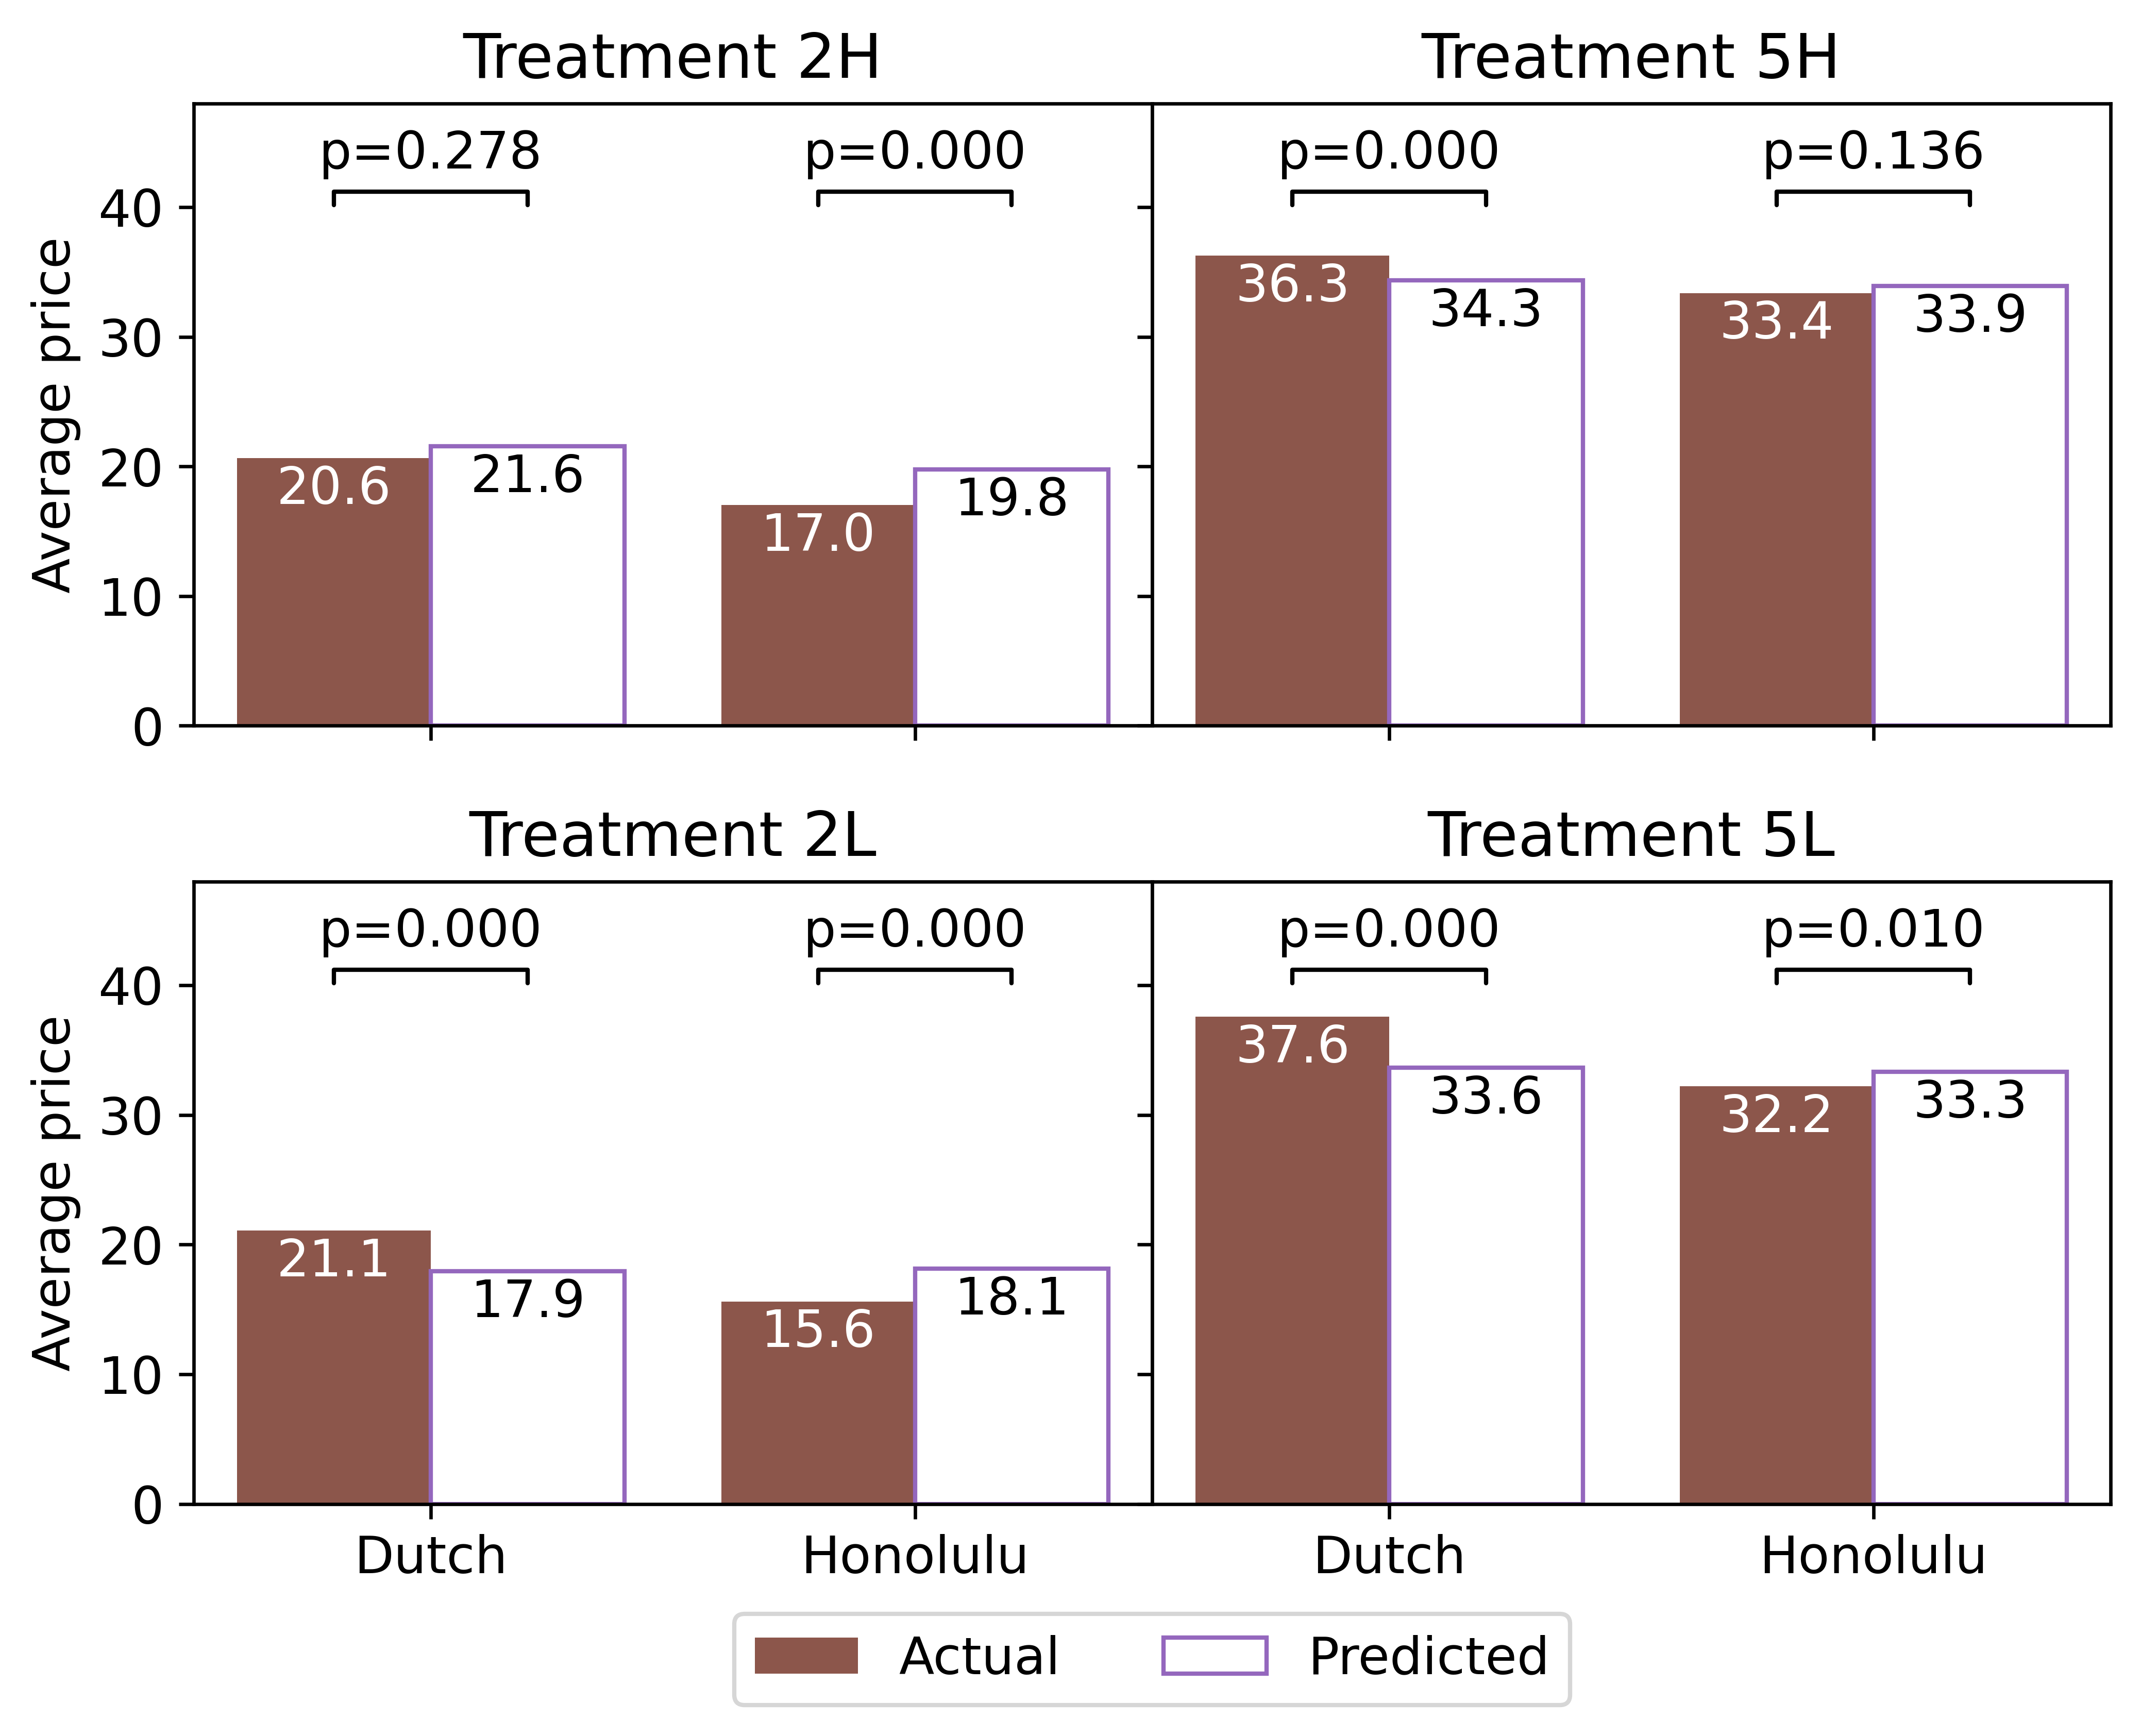

In [109]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=600, facecolor="white", sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.25)
Revenue(2, 0.019, ax[0, 0])
Revenue(2, 0.009, ax[1, 0])
Revenue(5, 0.019, ax[0, 1])
Revenue(5, 0.009, ax[1, 1])
plt.legend(ncol=2, loc="center", bbox_to_anchor=(0, -0.25), fontsize="large")

plt.savefig("bar_price_all_pyplot.png", bbox_inches="tight", format="png")

In [105]:
def Ub(n, b, ax):
    
    key1 = (n, b)
    
    tmp_a, tmp_p, tmp_z = [], [], []
    for key2 in dict_d[key1].keys():
        if dict_d[key1][key2]["have_winner"] > 0:
            tmp_a.append(dict_d[key1][key2]["ub"])
        tmp_p.append(dict_d[key1][key2]["pred_ub"])
        tmp_z.append(dict_d[key1][key2]["pred0_ub"])
    act_d, pre_d, pre0_d = np.average(tmp_a), np.average(tmp_p), np.average(tmp_z)
    
    tmp_a, tmp_p, tmp_z = [], [], []
    for key2 in dict_h[key1].keys():
        if dict_h[key1][key2]["have_winner"] > 0:
            tmp_a.append(dict_h[key1][key2]["ub"])
        tmp_p.append(dict_h[key1][key2]["pred_ub"])
        tmp_z.append(dict_h[key1][key2]["pred0_ub"])
    print([n, b, len(tmp_a), len(tmp_z), np.average(tmp_z), np.std(tmp_z)])
    act_h, pre_h, pre0_h = np.average(tmp_a), np.average(tmp_p), np.average(tmp_z)
      
    y1 = [act_d, act_h]
    y2 = [pre_d, pre_h]
    y3= [pre0_d, pre0_h]
    x = np.array([1, 2])

    wd = 0.4
    ax.bar(x - 0.5 * wd, y1, width=wd, color="C5", label="Actual")
    ax.bar(x + 0.5 * wd, y2, width=wd, edgecolor="C4", fill=False, label="Predicted")

    for ta, tb in zip(x, y1):
        ax.text(ta - 0.5 * wd, tb - 1.2, "%.1f" % tb, ha="center", color="white", fontsize="large")
    for ta, tb in zip(x, y2):
        ax.text(ta + 0.5 * wd, tb - 1.2, "%.1f" % tb, ha="center", color="black", fontsize="large")

    if n == 2:
        pval = 0.000 if b == 0.019 else 0.000
    else:
        pval = 0.200 if b == 0.019 else 0.002
    props = dict(
        connectionstyle = "bar, armA=0, armB=0, fraction=0.08",
        arrowstyle = "-",
        shrinkA = 0.5,
        shrinkB = 0.5,
        linewidth = 1,
    )
    ax.annotate("", (x[0] - 0.5 * wd, 15), (x[1] - 0.5 * wd, 15), arrowprops=props)
    ax.annotate("p=%.3f" % pval, (0.5 * (x[0] + x[1] - wd), 17), ha="center", fontsize="large")

    # wd = 0.2
    # ax.bar(x - wd, y1, width=wd, color="C5", label="Actual")
    # ax.bar(x, y2, width=wd, edgecolor="C4", fill=False, label="Predicted")
    # ax.bar(x + wd, y3, width=wd, edgecolor="C6", fill=False, hatch="//", label="Zero-cost predicted")

    # for ta, tb in zip(x, y1):
    #     ax.text(ta - wd, tb + 0.3, "%.1f" % tb, ha="center", color="black", fontsize="large")
    # for ta, tb in zip(x, y2):
    #     ax.text(ta, tb + 0.3, "%.1f" % tb, ha="center", color="black", fontsize="large")
    # for ta, tb in zip(x, y3):
    #     ax.text(ta + wd, tb + 0.3, "%.1f" % tb, ha="center", color="black", fontsize="large")

    # ax.set_ylim(0, 17)
    ax.set_ylim(0, 19)
    ax.set_yticks([0, 5, 10, 15], labels=[0, 5, 10, 15], fontsize="large")
    # ax.set_xticks(x, [str(n) + ("H" if b == 0.019 else "L") + "_Dutch",  str(n) + ("H" if b == 0.019 else "L") + "_Honolulu"])
    ax.set_xticks(x, labels=["Dutch", "Honolulu"], fontsize="large")
    if n == 2:
        ax.set_ylabel("Bidder payoff", fontsize="large")
    ax.set_title("Treatment " + str(n) + ("H" if b == 0.019 else "L"), fontsize="x-large")

[2, 0.019, 359, 360, 6.289294444444445, 6.426218026523344]
[2, 0.009, 341, 342, 12.409073099415206, 9.569442073290986]
[5, 0.019, 210, 210, 0.19710952380952382, 1.0132810508464742]
[5, 0.009, 196, 196, 4.710678571428572, 4.13365582793567]


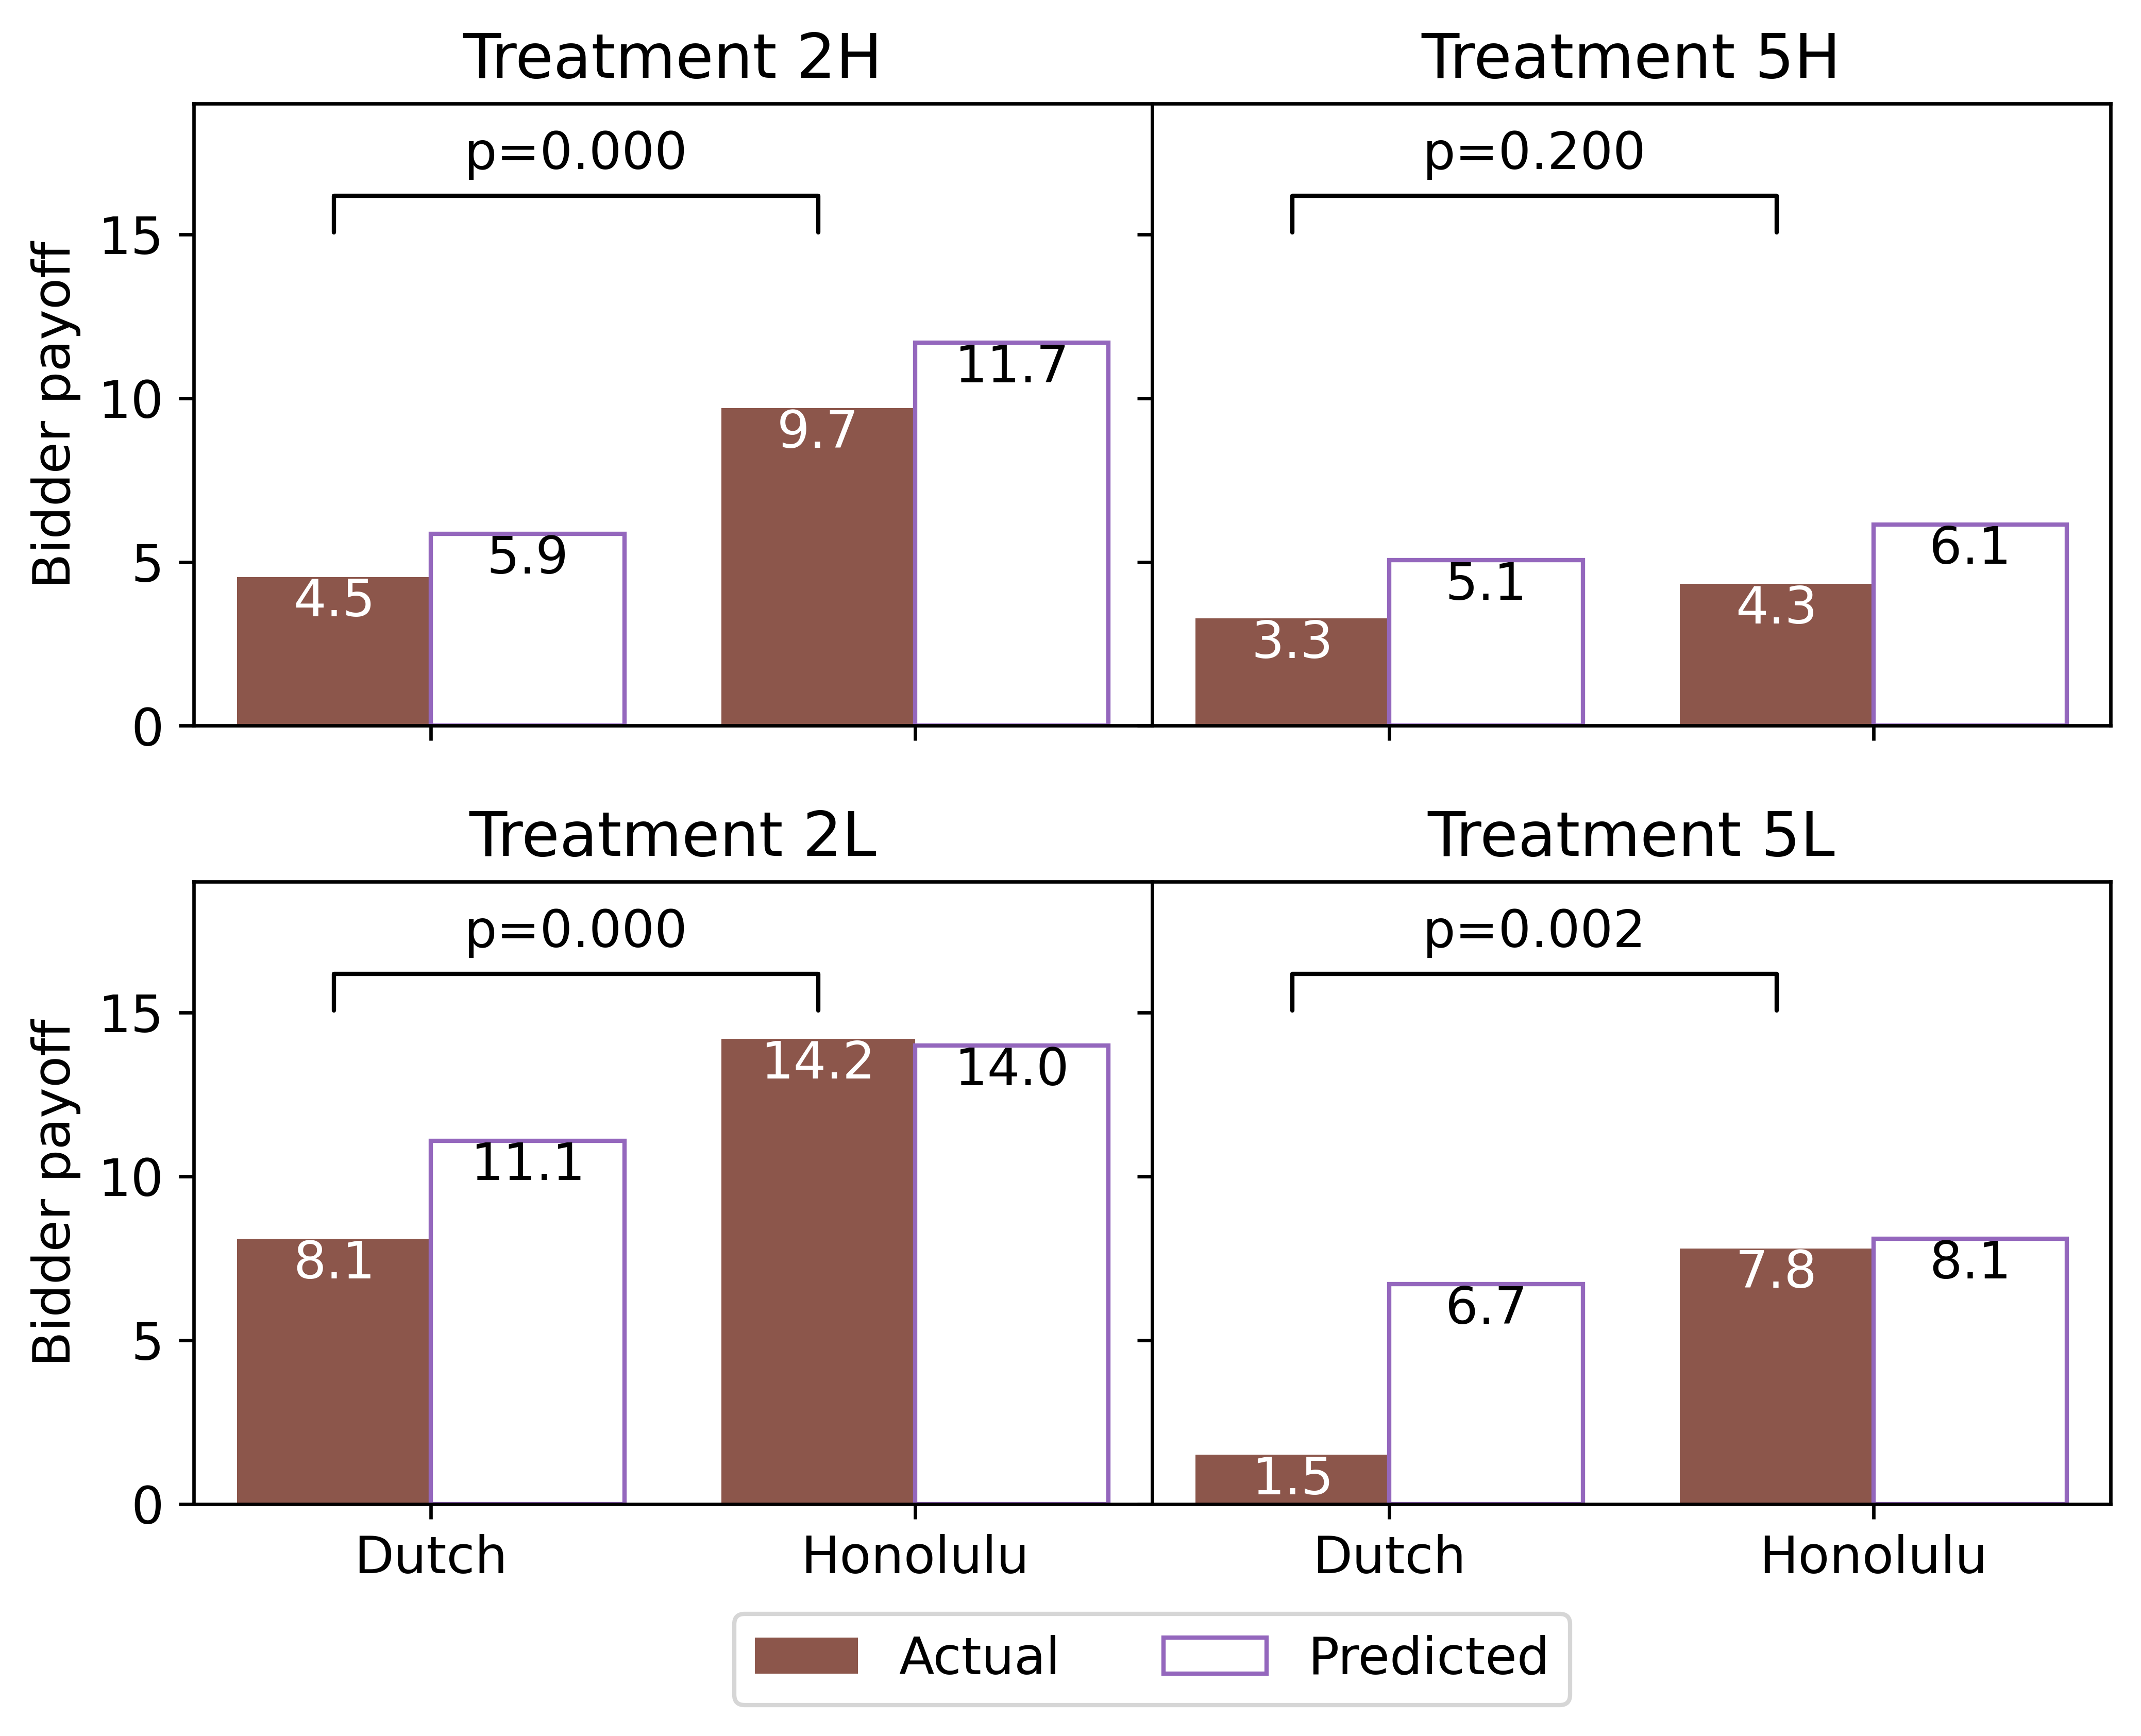

In [110]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=600, facecolor="white", sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.25)
Ub(2, 0.019, ax[0, 0])
Ub(2, 0.009, ax[1, 0])
Ub(5, 0.019, ax[0, 1])
Ub(5, 0.009, ax[1, 1])
plt.legend(ncol=2, loc="center", bbox_to_anchor=(0, -0.25), fontsize="large")

plt.savefig("bar_buyer_payoff_all_pyplot.png", bbox_inches="tight", format="png")

In [103]:
def Ua(n, b, ax):

    key1 = (n, b)

    tmp_a, tmp_p, tmp_z = [], [], []
    for key2 in dict_d[key1].keys():
        tmp_a.append(dict_d[key1][key2]["ua"])
        tmp_p.append(dict_d[key1][key2]["pred_ua"])
        tmp_z.append(dict_d[key1][key2]["pred0_ua"])
    act_d, pre_d, pre0_d = np.average(tmp_a), np.average(tmp_p), np.average(tmp_z)

    tmp_a, tmp_p, tmp_z = [], [], []
    for key2 in dict_h[key1].keys():
        tmp_a.append(dict_h[key1][key2]["ua"])
        tmp_p.append(dict_h[key1][key2]["pred_ua"])
        tmp_z.append(dict_h[key1][key2]["pred0_ua"])
    act_h, pre_h, pre0_h = np.average(tmp_a), np.average(tmp_p), np.average(tmp_z)
    
    y1 = [act_d, act_h]
    y2 = [pre_d, pre_h]
    y3 = [pre0_d, pre0_h]
    x = np.array([1, 2])
    
    wd = 0.4
    ax.bar(x - 0.5 * wd, y1, width=wd, color="C5", label="Actual")
    ax.bar(x + 0.5 * wd, y2, width=wd, edgecolor="C4", fill=False, label="Predicted")

    for ta, tb in zip(x, y1):
        ax.text(ta - 0.5 * wd, tb - 3, "%.1f" % tb, ha="center", color="white", fontsize="large")
    for ta, tb in zip(x, y2):
        ax.text(ta + 0.5 * wd, tb - 3, "%.1f" % tb, ha="center", color="black", fontsize="large")

    if n == 2:
        pval = 0.164 if b == 0.019 else 0.000
    else:
        pval = 0.002 if b == 0.019 else 0.000
    props = dict(
        connectionstyle = "bar, armA=0, armB=0, fraction=0.08",
        arrowstyle = "-",
        shrinkA = 0.5,
        shrinkB = 0.5,
        linewidth = 1,
    )
    ax.annotate("", (x[0] - 0.5 * wd, 30), (x[1] - 0.5 * wd, 30), arrowprops=props)
    ax.annotate("p=%.3f" % pval, (0.5 * (x[0] + x[1] - wd), 34), ha="center", fontsize="large")

    # wd = 0.2
    # ax.bar(x - wd, y1, width=wd, color="C5", label="Actual")
    # ax.bar(x, y2, width=wd, edgecolor="C4", fill=False, label="Predicted")
    # ax.bar(x + wd, y3, width=wd, edgecolor="C6", fill=False, hatch="//", label="Zero-cost predicted")

    # for ta, tb in zip(x, y1):
    #     ax.text(ta - wd, tb + 1, "%.1f" % tb, ha="center", color="black", fontsize="large")
    # for ta, tb in zip(x, y2):
    #     ax.text(ta, tb + 1, "%.1f" % tb, ha="center", color="black", fontsize="large")
    # for ta, tb in zip(x, y3):
    #     ax.text(ta + wd, tb + 1, "%.1f" % tb, ha="center", color="black", fontsize="large")

    # ax.set_ylim(0, 35)
    ax.set_ylim(0, 38)
    ax.set_yticks([0, 10, 20, 30], labels=[0, 10, 20, 30], fontsize="large")
    # ax.set_xticks(x, [str(n) + ("H" if b == 0.019 else "L") + "_Dutch", str(n) + ("H" if b == 0.019 else "L") + "_Honolulu"])
    ax.set_xticks(x, labels=["Dutch", "Honolulu"], fontsize="large")
    if n == 2:
        ax.set_ylabel("Auctioneer payoff", fontsize="large")
    ax.set_title("Treatment " + str(n) + ("H" if b == 0.019 else "L"), fontsize="x-large")

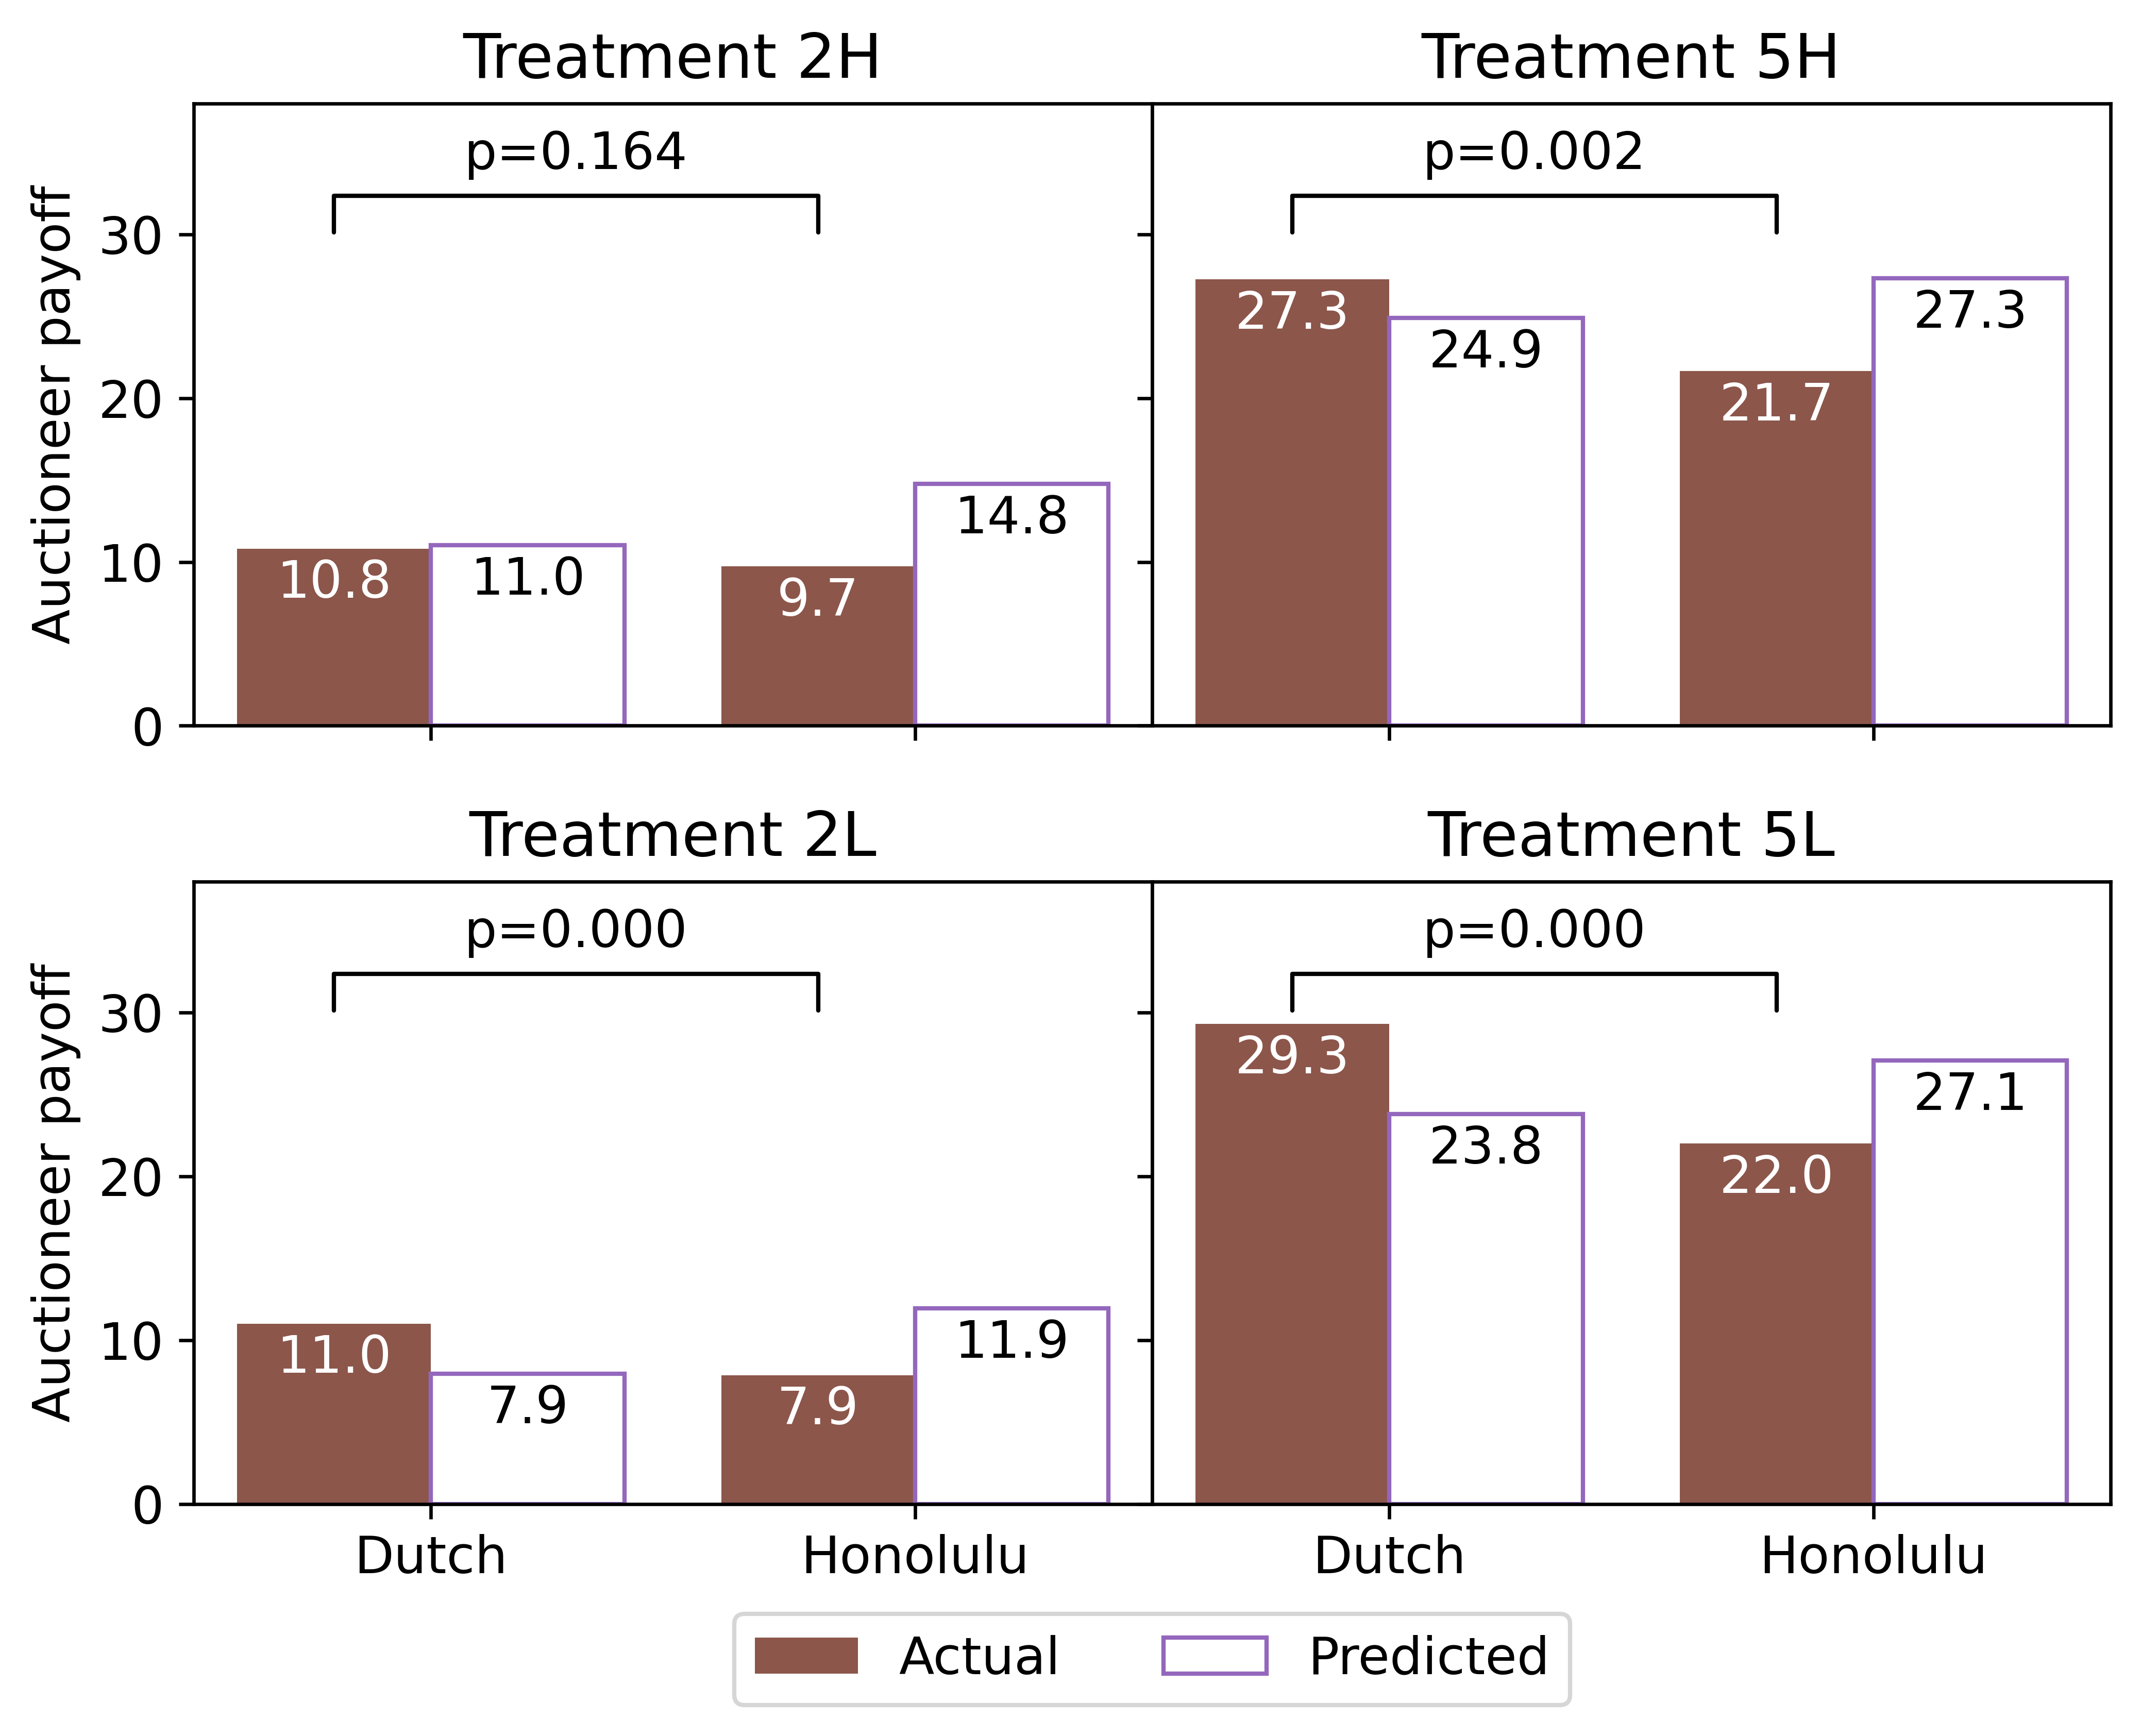

In [111]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=600, facecolor="white", sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.25)
Ua(2, 0.019, ax[0, 0])
Ua(2, 0.009, ax[1, 0])
Ua(5, 0.019, ax[0, 1])
Ua(5, 0.009, ax[1, 1])
plt.legend(ncol=2, loc="center", bbox_to_anchor=(0, -0.25), fontsize="large")

plt.savefig("bar_seller_payoff_all_pyplot.png", bbox_inches="tight", format="png")

## Bid deviation

In [8]:
# dutch auction bid deviations between top and bottom earners

def dutchDeviation(n, b):
    tmp = df_d[(df_d["session.config.name"].str.contains(str(n) + "_")) & (df_d["session.config.discount_b"] == b)]
    qlist = tmp["paydiff_pct"].unique()
    tmp = tmp[tmp["player.is_dutch_winner"] == 1]

    # drop outliers with 1/3 or more bids that bid > value + 2
    # plist = tmp["participant.code"].unique()
    # droplist = []
    # for p in plist:
    #     n_all = len(tmp[tmp["participant.code"] == p])
    #     n_sd = len(tmp[(tmp["participant.code"] == p) & (tmp["player.item_value"] + 2 < tmp["group.dutch_final_price"])])
    #     if (n_sd / n_all >= 1 / 3):
    #         droplist.append(p)
    # tmp = tmp[~tmp["participant.code"].isin(droplist)]
    # print(droplist)

    tmp_top = tmp[(tmp["paydiff_pct"] > np.quantile(qlist, 0.5)) & (tmp["paydiff_pct"] <= np.quantile(qlist, 1))]
    tmp_bot = tmp[(tmp["paydiff_pct"] >= np.quantile(qlist, 0)) & (tmp["paydiff_pct"] <= np.quantile(qlist, 0.5))]

    act_top = tmp_top["group.dutch_final_price"]
    pre_top = tmp_top["predict.player.bid"]
    act_bot = tmp_bot["group.dutch_final_price"]
    pre_bot = tmp_bot["predict.player.bid"]
    return np.mean(act_top) - np.mean(pre_top), np.mean(act_bot) - np.mean(pre_bot)

In [20]:
def plotDbid():

    x = np.array([1, 2, 3, 4])
    wd = 0.3
    ybot = -7
    ytop = 12
    y1 = []
    y2 = []
    for n in [2, 5]:
        for b in [0.019, 0.009]:
            tmp1, tmp2 = dutchDeviation(n, b)
            y1.append(tmp1)
            y2.append(tmp2)
    plt.bar(x - 0.5 * wd, y1, width=wd, color="maroon", label="Top")
    plt.bar(x + 0.5 * wd, y2, width=wd, color="darkolivegreen", label="Bottom")
    plt.axhline(0, color="grey", linewidth=1, alpha=0.5)

    for a, b in zip(x, y1):
        if b >= 0:
            plt.text(a - 0.5 * wd, b + 0.3, "%.1f" % b, ha="center", color="black", fontsize="medium")
        else:
            plt.text(a - 0.5 * wd, b - 0.8, "%.1f" % b, ha="center", color="black", fontsize="medium")
    for a, b in zip(x, y2):
        if b >= 0:
            plt.text(a + 0.5 * wd, b + 0.3, "%.1f" % b, ha="center", color="black", fontsize="medium")
        else:
            plt.text(a + 0.5 * wd, b - 0.8, "%.1f" % b, ha="center", color="black", fontsize="medium")

    props = dict(
        connectionstyle = "bar, armA=0, armB=0, fraction=0.08",
        arrowstyle = "-",
        shrinkA = 0.5,
        shrinkB = 0.5,
        linewidth = 1,
    )
    p = [0.053, 0.027, 0.000, 0.000]
    for i in range(len(x)):
        plt.annotate("", (x[i] - 0.5 * wd, ytop - 2), (x[i] + 0.5 * wd, ytop - 2), arrowprops=props)
        plt.annotate("p=%.3f" % p[i], (x[i], ytop - 1.5), ha="center", fontsize="medium")

    plt.ylim(ybot, ytop)
    plt.xticks(x, ["High", "Low", "High", "Low"])
    plt.ylabel("Mean deviation, points")

    plt.annotate("2 bidders", (1.5, ybot), (1.5, ybot-2.5), ha="center", fontsize="medium")
    plt.annotate("5 bidders", (3.5, ybot), (3.5, ybot-2.5), ha="center", fontsize="medium")
    # plt.legend(ncol=2, loc="center", bbox_to_anchor=(0.5, -0.25))
    plt.title("Dutch auction", pad=10, fontsize="large")

In [10]:
# dutch stage bid deviations between top and bottom earners

def dutchStageDeviation(n, b):
    tmp = df_h[(df_h["session.config.name"].str.contains(str(n) + "_")) & (df_h["session.config.discount_b"] == b)]
    qlist = tmp["paydiff_pct"].unique()
    tmp = tmp[tmp["player.is_dutch_winner"] == 1]

    # drop outliers with 1/3 or more bids that bid > value + 2
    # plist = tmp["participant.code"].unique()
    # droplist = []
    # for p in plist:
    #     n_all = len(tmp[tmp["participant.code"] == p])
    #     n_sd = len(tmp[(tmp["participant.code"] == p) & (tmp["player.item_value"] + 2 < tmp["group.dutch_final_price"])])
    #     if (n_sd / n_all >= 1 / 3):
    #         droplist.append(p)
    # tmp = tmp[~tmp["participant.code"].isin(droplist)]
    # print(droplist)

    tmp_top = tmp[(tmp["paydiff_pct"] > np.quantile(qlist, 0.5)) & (tmp["paydiff_pct"] <= np.quantile(qlist, 1))]
    tmp_bot = tmp[(tmp["paydiff_pct"] >= np.quantile(qlist, 0)) & (tmp["paydiff_pct"] <= np.quantile(qlist, 0.5))]

    act_top = tmp_top["group.dutch_final_price"]
    pre_top = tmp_top["predict.player.optimal_dutch_bid"]
    act_bot = tmp_bot["group.dutch_final_price"]
    pre_bot = tmp_bot["predict.player.optimal_dutch_bid"]
    
    return np.mean(act_top) - np.mean(pre_top), np.mean(act_bot) - np.mean(pre_bot)

In [19]:
def plotDstage():

    x = np.array([1, 2, 3, 4])
    wd = 0.3
    ybot = -7
    ytop = 12
    y1 = []
    y2 = []
    for n in [2, 5]:
        for b in [0.019, 0.009]:
            tmp1, tmp2 = dutchStageDeviation(n, b)
            y1.append(tmp1)
            y2.append(tmp2)
    plt.bar(x - 0.5 * wd, y1, width=wd, color="maroon", label="Top")
    plt.bar(x + 0.5 * wd, y2, width=wd, color="darkolivegreen", label="Bottom")
    plt.axhline(0, color="grey", linewidth=1, alpha=0.5)

    for a, b in zip(x, y1):
        if b >= 0:
            plt.text(a - 0.5 * wd, b + 0.3, "%.1f" % b, ha="center", color="black", fontsize="medium")
        else:
            plt.text(a - 0.5 * wd, b - 0.8, "%.1f" % b, ha="center", color="black", fontsize="medium")
    for a, b in zip(x, y2):
        if b >= 0:
            plt.text(a + 0.5 * wd, b + 0.3, "%.1f" % b, ha="center", color="black", fontsize="medium")
        else:
            plt.text(a + 0.5 * wd, b - 0.8, "%.1f" % b, ha="center", color="black", fontsize="medium")

    props = dict(
        connectionstyle = "bar, armA=0, armB=0, fraction=0.08",
        arrowstyle = "-",
        shrinkA = 0.5,
        shrinkB = 0.5,
        linewidth = 1,
    )
    p = [0.009, 0.954, 0.718, 0.436] # [0.000, 0.954, 0.611, 0.436]
    for i in range(len(x)):
        plt.annotate("", (x[i] - 0.5 * wd, ytop - 2), (x[i] + 0.5 * wd, ytop - 2), arrowprops=props)
        plt.annotate("p=%.3f" % p[i], (x[i], ytop - 1.5), ha="center", fontsize="medium")

    plt.ylim(ybot, ytop)
    plt.xticks(x, ["High", "Low", "High", "Low"])
    plt.ylabel("Mean deviation, points")

    plt.annotate("2 bidders", (1.5, ybot), (1.5, ybot-2.5), ha="center", fontsize="medium")
    plt.annotate("5 bidders", (3.5, ybot), (3.5, ybot-2.5), ha="center", fontsize="medium")
    # plt.legend(ncol=2, loc="center", bbox_to_anchor=(0.5, -0.25))
    plt.title("Dutch stage of Honolulu-Sydney auction", pad=10, fontsize="large")

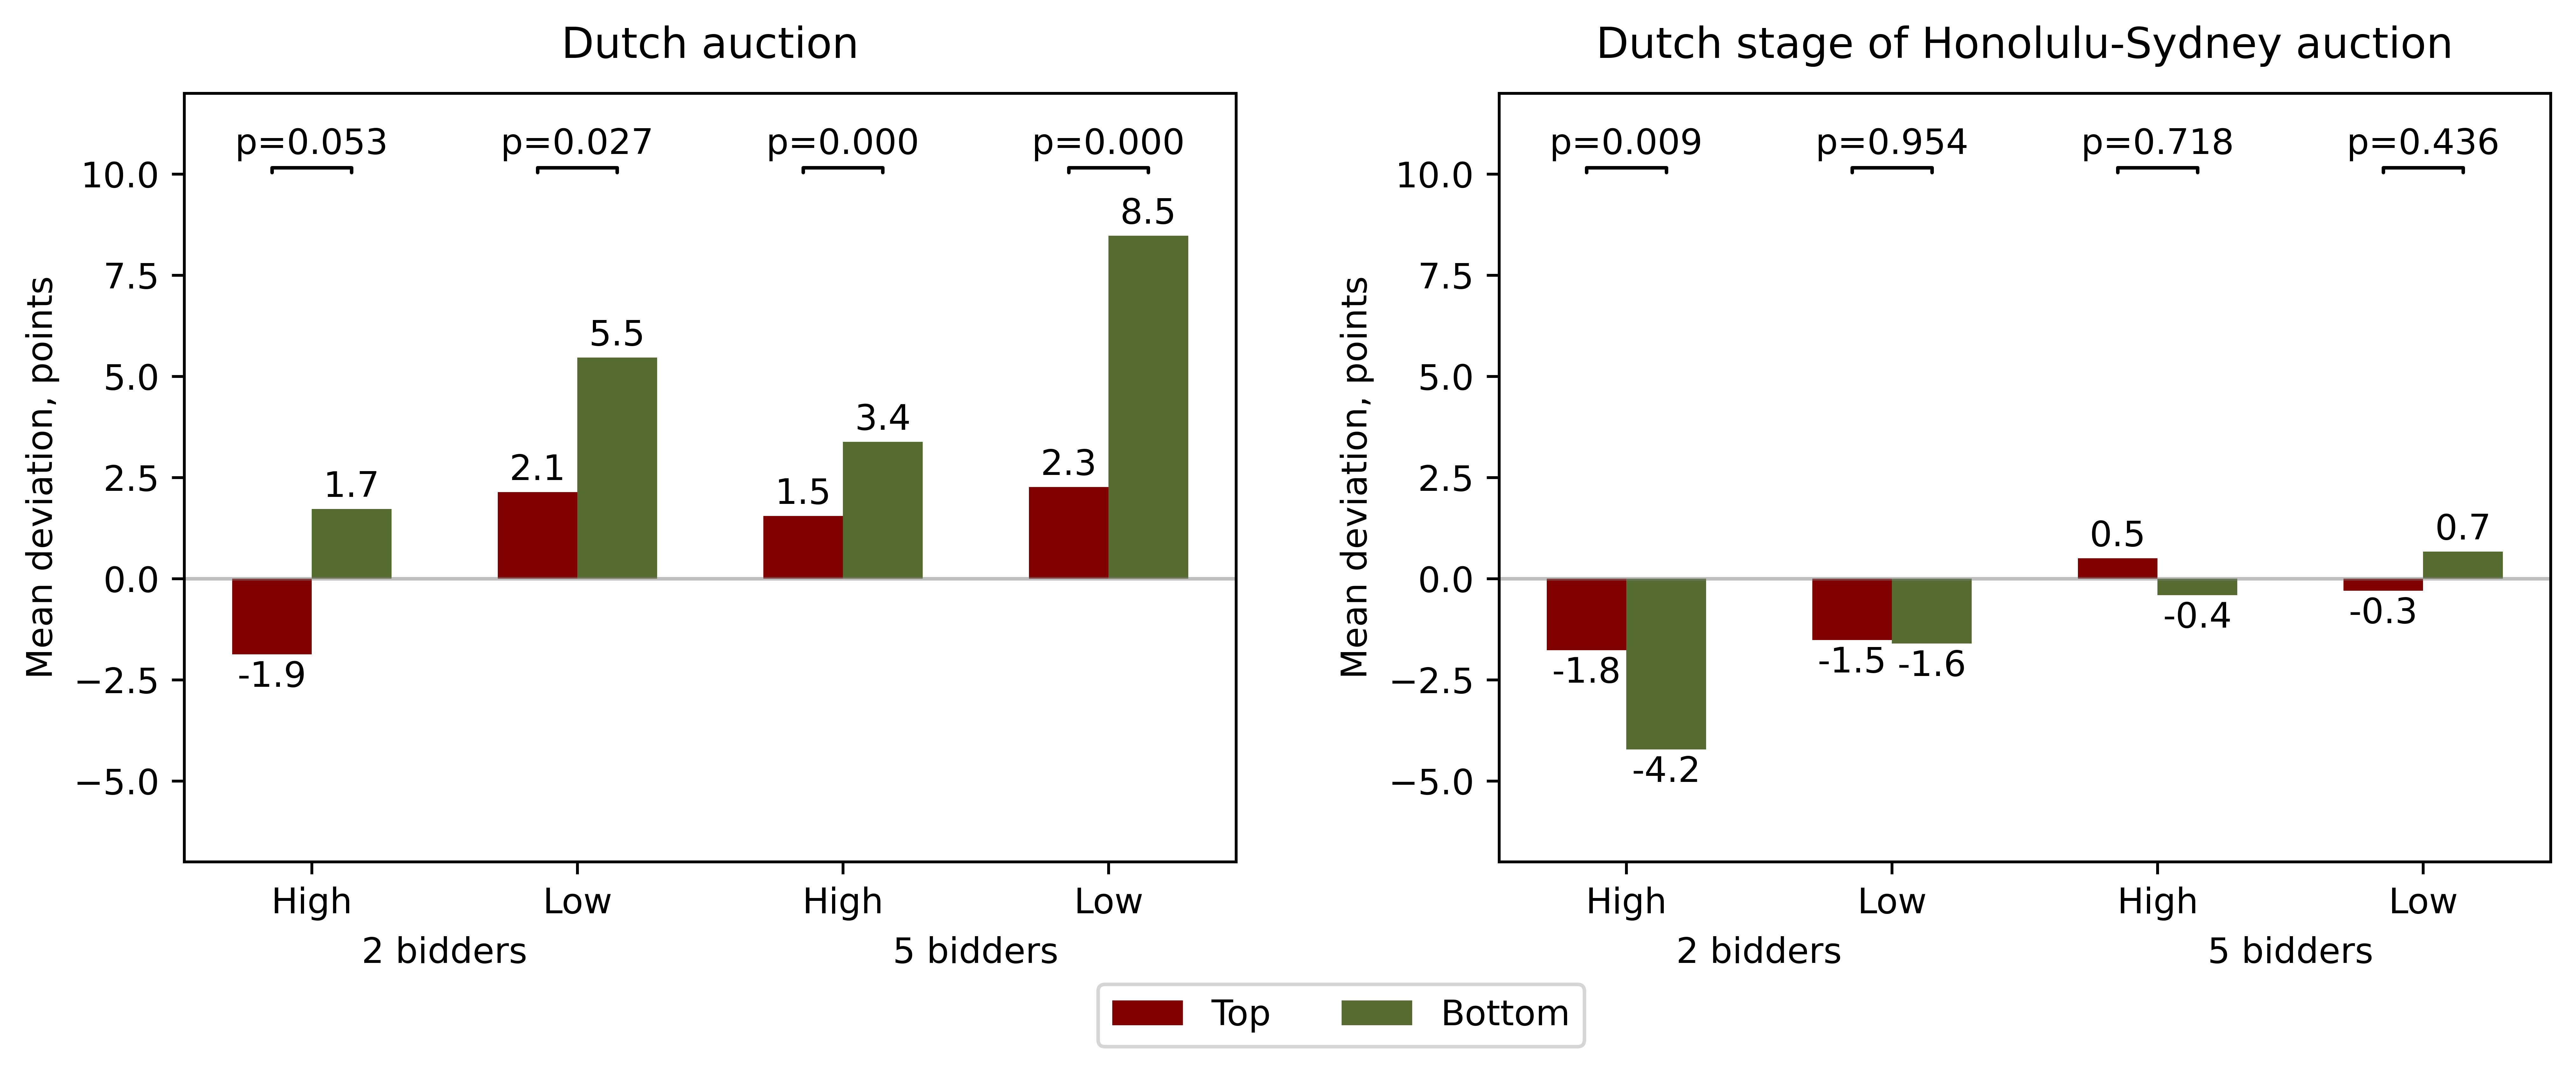

In [21]:
plt.figure(figsize=(12, 4), dpi=800)
plt.subplots_adjust(wspace=0.25, hspace=0.5)
plt.subplot(121)
plotDbid()
plt.subplot(122)
plotDstage()
plt.legend(ncol=2, loc="center", bbox_to_anchor=(-0.15, -0.2), fontsize="medium")

plt.savefig("dutch_bid_deviations_pyplot.png", bbox_inches="tight", format="png")

In [148]:
# dutch stage bid deviations between predicted and not predicted winners

def dutchStageDeviation2(n, b):
    tmp = df_h[(df_h["session.config.name"].str.contains(str(n) + "_")) & (df_h["session.config.discount_b"] == b)]
    tmp = tmp[tmp["player.is_dutch_winner"] == 1]

    tmp_npred = tmp[tmp["predict.player.is_dutch_winner"] == 0]
    tmp_pred = tmp[tmp["predict.player.is_dutch_winner"] == 1]

    act_npred = tmp_npred["group.dutch_final_price"]
    pre_npred = tmp_npred["predict.player.optimal_dutch_bid"]
    act_pred = tmp_pred["group.dutch_final_price"]
    pre_pred = tmp_pred["predict.player.optimal_dutch_bid"]
    
    return np.mean(act_npred) - np.mean(pre_npred), np.mean(act_pred) - np.mean(pre_pred)

In [149]:
def plotDstage2():

    x = np.array([1, 2, 3, 4])
    wd = 0.3
    ybot = -6
    ytop = 6
    y1 = []
    y2 = []
    for n in [2, 5]:
        for b in [0.019, 0.009]:
            tmp1, tmp2 = dutchStageDeviation2(n, b)
            y1.append(tmp1)
            y2.append(tmp2)
    plt.bar(x - 0.5 * wd, y1, width=wd, color="maroon", label="Not Predicted")
    plt.bar(x + 0.5 * wd, y2, width=wd, color="darkolivegreen", label="Predicted")
    plt.axhline(0, color="grey", linewidth=1, alpha=0.5)

    for a, b in zip(x, y1):
        if b >= 0:
            plt.text(a - 0.5 * wd, b + 0.3, "%.1f" % b, ha="center", color="black", fontsize="medium")
        else:
            plt.text(a - 0.5 * wd, b - 0.8, "%.1f" % b, ha="center", color="black", fontsize="medium")
    for a, b in zip(x, y2):
        if b >= 0:
            plt.text(a + 0.5 * wd, b + 0.3, "%.1f" % b, ha="center", color="black", fontsize="medium")
        else:
            plt.text(a + 0.5 * wd, b - 0.8, "%.1f" % b, ha="center", color="black", fontsize="medium")

    props = dict(
        connectionstyle = "bar, armA=0, armB=0, fraction=0.08",
        arrowstyle = "-",
        shrinkA = 0.5,
        shrinkB = 0.5,
        linewidth = 1,
    )
    p = [0.000, 0.000, 0.001, 0.000]
    for i in range(len(x)):
        plt.annotate("", (x[i] - 0.5 * wd, ytop - 1.5), (x[i] + 0.5 * wd, ytop - 1.5), arrowprops=props)
        plt.annotate("p=%.3f" % p[i], (x[i], ytop - 1), ha="center", fontsize="medium")

    plt.ylim(ybot, ytop)
    plt.xticks(x, ["High", "Low", "High", "Low"])
    plt.ylabel("Mean deviation, points")

    plt.annotate("2 bidders", (1.5, ybot), (1.5, ybot-1.5), ha="center", fontsize="medium")
    plt.annotate("5 bidders", (3.5, ybot), (3.5, ybot-1.5), ha="center", fontsize="medium")
    # plt.legend(ncol=2, loc="center", bbox_to_anchor=(0.5, -0.25))
    plt.title("Dutch stage bid deviations from theory", pad=10, fontsize="large")

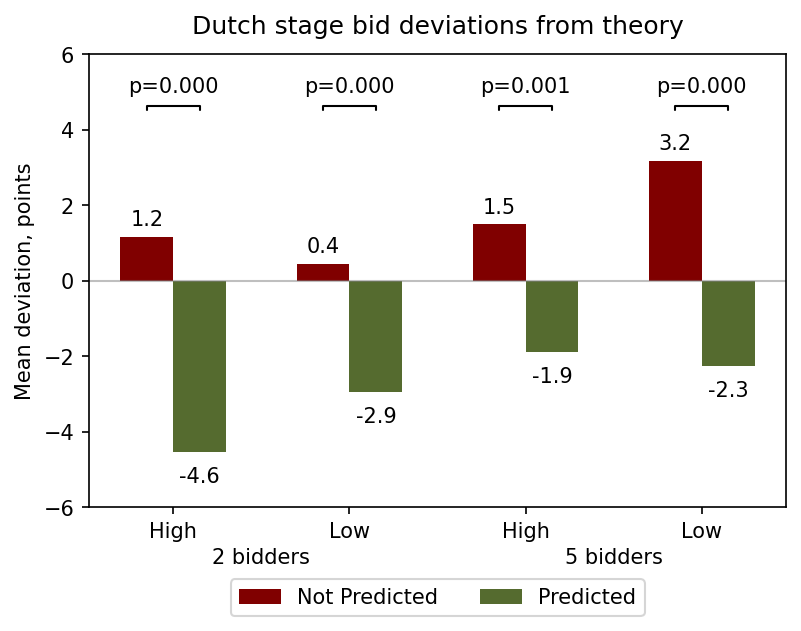

In [152]:
plt.figure(figsize=(6, 4), dpi=150)
plotDstage2()
plt.legend(ncol=2, loc="center", bbox_to_anchor=(0.5, -0.2), fontsize="medium")

plt.savefig("dutch_stage_bid_deviations_pyplot.png", bbox_inches="tight", format="png")